In [1]:
import numpy as np
from collections import Counter
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import nltk
import re
import requests
import csv
from sklearn import svm
import zipfile
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.snowball import ItalianStemmer
! spacy download it
#SpaCy is a free open-source library for Natural Language Processing
import spacy
#import an available pretrained statistical models for Italian
import it_core_news_sm
#Calling the nlp object on a string of text will return a processed Doc
nlp = it_core_news_sm.load()

     |████████████████████████████████| 11.1MB 829kB/s 
  Created wheel for it-core-news-sm: filename=it_core_news_sm-2.1.0-cp36-none-any.whl size=11123297 sha256=61fbbddbe11e3f45e6298daa7b53e46428b653e465e96cea7c2a317003cb1d92
  Stored in directory: /tmp/pip-ephem-wheel-cache-k1yxg_up/wheels/8a/7b/11/1010c25163c5166f22f68205123898a33cbe535e0f7525a9ab
Successfully built it-core-news-sm
✔ Download and installation successful
You can now load the model via spacy.load('it_core_news_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/it_core_news_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/it
You can now load the model via spacy.load('it')


DO STOPWORDS

In [0]:
request=requests.get('https://gist.githubusercontent.com/enryold/0676352e48788a24fe792e66b7e99e3c/raw/a182501d03bf1b52001706f932a72606a443c50a/Italian%2520woman%2520names', allow_redirects=True)
open('femalepropernames.txt', 'wb').write(request.content)    

request=requests.get('https://raw.githubusercontent.com/Alir3z4/stop-words/master/italian.txt')
open('stopwords.txt', 'wb').write(request.content)

request=requests.get('https://gist.githubusercontent.com/marciuz/5874431/raw/65d9dfaadcb8d68aecf8ff48f0e2683b06600737/first_name_ITA_M.txt', allow_redirects=True)
open('malepropernames.txt', 'wb').write(request.content) 

SW = open('stopwords.txt', 'r', encoding='utf-8').read().lower().splitlines()
SW+=('lunedi lunedì martedì martedi mercoledi mercoledì giovedi giovedì venerdi venerdì sabato domenica gennaio febbraio marzo aprile maggio giugno luglio agosto settembre ottobre novembre dicembre').split()
SW += open('malepropernames.txt', 'r', encoding='utf-8').read().lower().splitlines()
SW += open('femalepropernames.txt', 'r', encoding='utf-8').read().lower().splitlines()

#Rimuovo il "non"
SW.remove('non')

DATA LOADING


In [0]:
request=requests.get('http://dbdmg.polito.it/wordpress/wp-content/uploads/2020/01/dataset_winter_2020.zip')
open('dataset_winter_2020.zip', 'wb').write(request.content)
with zipfile.ZipFile('dataset_winter_2020.zip', 'r') as zip_fol:
    zip_fol.extractall('.')

labelled_df=pd.read_csv('./development.csv')
number_of_labelled=len(labelled_df)
evaluation_df=pd.read_csv('./evaluation.csv')
total_df=labelled_df.append(evaluation_df, sort=False).reset_index().drop(columns='index')

Qualche statistica sui dataset

In [4]:
num_pos_reviews=(labelled_df['class']=='pos').sum()
num_neg_reviews=(labelled_df['class']=='neg').sum()
print(f"Numero totale di positive reviews: {num_pos_reviews}")
print(f"Numero totale di negative reviews: {num_neg_reviews}")

#se ho una series e ci faccio .str, vedo ogni elemento della serie come una stringa
#qui ritorna una lista di boolean a secondo che ci sia quella espressione o no,
#e poi la sommmo cosi ho IL NUMERO DI REVIEWS CHE LA CONTENGONO, NON IL NUMERO TOT DI VOLTE IN CUI COMPARE IN TUTTE LE REVIEW
evaluation_df['text'].str.contains('luglio',regex=False).sum()

Numero totale di positive reviews: 19532
Numero totale di negative reviews: 9222


140

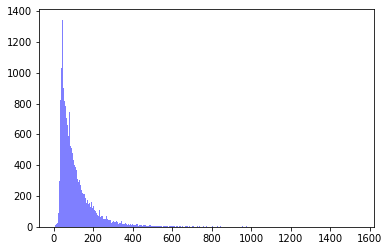

In [5]:
#calcola lunghezza in words di ogni review (in questo caso del labelled_df)
vettore_lunghezze=[]
for review in labelled_df['text'].tolist():
  parole=review.split()
  vettore_lunghezze.append(len(parole))
plt.hist(vettore_lunghezze, 500, facecolor='blue',alpha=0.5)
plt.show()

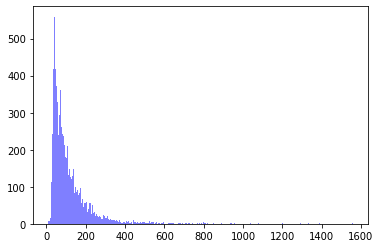

In [6]:
#qui dell'evaluation
vettore_lunghezze=[]
for review in evaluation_df['text'].tolist():
  parole=review.split()
  vettore_lunghezze.append(len(parole))
plt.hist(vettore_lunghezze, 500, facecolor='blue',alpha=0.5)
plt.show()

In [7]:
labelled_df['num_words'] = labelled_df['text'].apply(lambda x: len(x.split()))
labelled_df

,text,class,num_words
0,Non è l'hotel più lussuoso in cui abbia mai so...,pos,715
1,Siamo stati qui per 1 notte prima della nostra...,pos,49
2,Hotel è ben posizionato per visitare Torino. A...,pos,58
3,All'arrivo la cordialità e disponibilità dello...,pos,36
4,Abbiamo soggiornato per due notti alla fine de...,pos,62
...,...,...,...
28749,L'hotel è vecchio ma caratteristico e devo dir...,neg,152
28750,Per essere un 4 stelle L la camera era un pò s...,pos,117
28751,Io e mia mamma (di età compresa tra 23 e 62) s...,pos,272
28752,Ci siamo sentiti accolti e coccolati fin dall'...,pos,106


LUNGHEZZA PAROLE E POS O NEG DELLA REVIEW NEL DEVELOPMENT SET

In [8]:
import plotly.graph_objs as go
from plotly.tools import FigureFactory as FF
from plotly.offline import iplot

x1 = labelled_df.loc[labelled_df['class'] == 'neg', 'num_words']
x0 = labelled_df.loc[labelled_df['class'] == 'pos', 'num_words']

trace1 = go.Histogram(
    x=x0, name='Pos',
    opacity=0.75
)
trace2 = go.Histogram(
    x=x1, name = 'Neg',
    opacity=0.75
)

data = [trace1, trace2]
layout = go.Layout(barmode = 'group', title='Distribution of Review Lengths Based on Recommendation')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='stacked histogram')

In [9]:
#DA AGGIUNGERE COME FEATURES??
#statistiche sul labelled dataset
for word in ['\w![^!]','\?','!\?','\?!','[^!]!![^!]','!{3}','\?\?', '\?{3}']:
    print(word, (np.array(total_df['class'][:number_of_labelled]  == 'pos') & np.array(total_df['text'][:number_of_labelled].str.contains(word, regex=True))).sum() / np.array(total_df['text'][:number_of_labelled].str.contains(word, regex=True)).sum() * 100, "nelle positive")
    print(word, (np.array(total_df['text'][:number_of_labelled].str.contains(word, regex=True))).sum()/number_of_labelled*100, 'nelle labelled')

\w![^!] 66.26086956521739 nelle positive
\w![^!] 21.996939556235652 nelle labelled
\? 33.82352941176471 nelle positive
\? 6.148709744731168 nelle labelled
!\? 12.048192771084338 nelle positive
!\? 0.28865549140989083 nelle labelled
\?! 22.5 nelle positive
\?! 0.5564443207901509 nelle labelled
[^!]!![^!] 51.792114695340494 nelle positive
[^!]!![^!] 3.881199137511303 nelle labelled
!{3} 49.46949602122016 nelle positive
!{3} 7.8667315851707595 nelle labelled
\?\? 16.716417910447763 nelle positive
\?\? 1.1650552966543786 nelle labelled
\?{3} 13.636363636363635 nelle positive
\?{3} 0.7651109410864576 nelle labelled


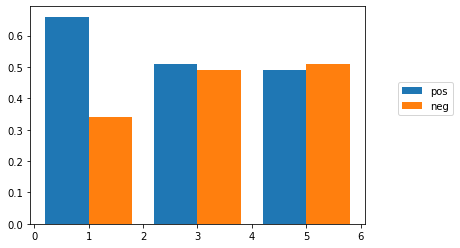

In [10]:

X = np.array([1,3,5]) #! !! !!!
Y = [0.66,0.51,0.49] #pos
Z = [0.34,0.49,0.51] #neg

plt.bar(X - 0.4, Y, label='pos') # offset of -0.4
plt.bar(X + 0.4, Z, label='neg') # offset of  0.4
plt.legend(loc=(1.1,0.5))
plt.show()

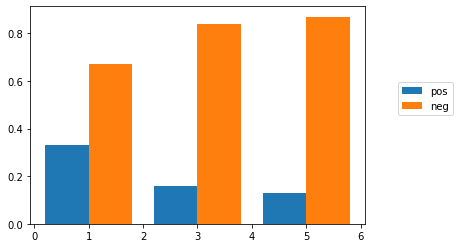

In [11]:
X = np.array([1,3,5]) #? ?? ???
Y = [0.33,0.16,0.13] #pos
Z = [0.67,0.84,0.87] #neg

plt.bar(X - 0.4, Y, label='pos') # offset of -0.4
plt.bar(X + 0.4, Z, label='neg') # offset of  0.4
plt.legend(loc=(1.1,0.5))
plt.show()

ANALIZZO EMOJI EMOTICONS E AGGIUNGO LA LORO FEATURE

In [12]:
neg_emojis = '👿🖕😾😡😠😧💔💩😱🙀😭😟👎😰😖😕😢😿😞🤕😨😳☹️😬🤥🤢😣💀☠️🤧😫😒😩😥😵👊😦😯😷😔🙄🙁😓🤔🤐'
pos_emojis = '🤝😆🙏🙂😛😎👍😲😊🤠🤞😁😀🤗💋😗😽😚😙👄👌☺️😌😄😸😃😺😏😼😅✌️💯🖤💙👏💘💝💚❤️😍😻💓💗😇😂😹😘💜💞💖💕😉💛😋🙌🤣'
pos_emojis_regex='|'.join(list(pos_emojis))
pos_emoticons_regex='<3|:-\)|;\)|;-\)|:\)'
neg_emojis_regex='|'.join(list(neg_emojis))
neg_emoticons_regex=':\(|:-\(|-_-|;\(|;-\(|-\.-'
#fai statistica per labelled e per evaluation magari
pos_emot_emoji_count = total_df['text'].str.contains(pos_emoticons_regex+'|'+pos_emojis_regex,regex=True).sum()
#è il numero di documenti (tra labelled e non) che ha almeno una emoticons o emoji positiva 
neg_emot_emoji_count = total_df['text'].str.contains(neg_emoticons_regex+'|'+neg_emojis_regex,regex=True).sum()
#idem per le negative
print(pos_emot_emoji_count)
print(neg_emot_emoji_count)

624
162


In [0]:
#FEATURE SUL DATASET TOTALE
total_df['has_pos_emoj_emot'] = total_df['text'].str.contains(pos_emoticons_regex+'|'+pos_emojis_regex,regex=True) 
total_df['has_neg_emoj_emot'] = total_df['text'].str.contains(neg_emoticons_regex+'|'+neg_emojis_regex,regex=True)

STATISTICHE SULLE REVIEWS CON EMOJI EMOTS

In [14]:
arr1=np.array(total_df['has_pos_emoj_emot'][:number_of_labelled] == True) #array con True se hanno emoj_emot pos (tra le labelled)
arr2=np.array(total_df['class'][:number_of_labelled] == 'pos') #array con indici True se sono reviews pos (tra le labelled)
print(np.array(arr1 & arr2).sum()/arr1.sum())

arr1=np.array(total_df['has_neg_emoj_emot'][:number_of_labelled] == True) #array con True se hanno emoj_emot neg (tra le labelled)
arr2=np.array(total_df['class'][:number_of_labelled] == 'neg') #array con indici True se sono reviews neg (tra le labelled)
print(np.array(arr1 & arr2).sum()/arr1.sum())

0.8832951945080092
0.6050420168067226


TOKENIZER LEMMATIZER STEMMATIZER

In [0]:
stemmer = ItalianStemmer()

def tokenizer_lemm_stemm(review):
    #review è stringa
    review=re.sub('[^abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZÀÁÈÉÌÍÒÓÙÚàáèéìíòóùú ]',' ', review)
    #ora review è stringa in cui tutti i char che non siano tra quelli scritti(lì ho anche lo spazio) sono sostituiti da uno spazio.
    #quindi tolti i numeri e TUTTA la punteggiatura
    review=review.lower() #review è una stringa e la converto a lowercase tutta
    tokens=[token.strip() for token in review.split() if token not in SW] #tokens è lista di stringhe

    doc=nlp(' '.join(tokens)) #doc è una "striigna speciale" con la review dopo il processo di prima
    tokens=[token.lemma_ for token in doc]
    tokens=[stemmer.stem(token) for token in tokens]
    return tokens

LO APPLICO ALL'INTERO DATASET

In [0]:
total_df['text_tokenized_lemmed'] = total_df['text'].apply(tokenizer_lemm_stemm)

FACCIO WORDCLOUD DELLE REVIEWS LABELLATE DOPO TOKEN LEM STEMM

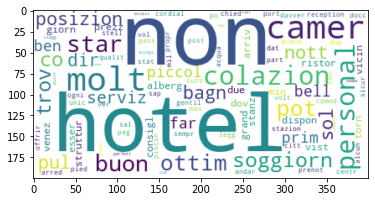

In [17]:
all_tokenized_lemmed_wordscloud = ' '.join([' '.join(review) for review in total_df['text_tokenized_lemmed'][:number_of_labelled]])
#stringa con tutte le parole dopo il tokenizer_lemm_stemm, di tutti i documenti labellati (considerati anche i doppioni)
plt.imshow(WordCloud(collocations=False, stopwords=[], max_font_size=100, max_words=100, background_color="white", random_state=1).generate(all_tokenized_lemmed_wordscloud), 
            interpolation='bilinear')

FACCIO WORDCLOUD DELLE REVIEWS NON LABELLATE DOPO TOKEN LEM STEMM

11251988
4810836


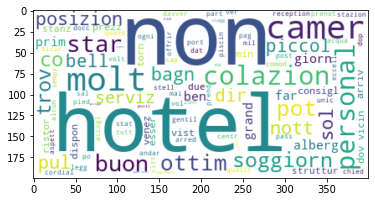

In [18]:
all_tokenized_lemmed_wordscloud2 = ' '.join([' '.join(review) for review in total_df['text_tokenized_lemmed'][number_of_labelled:]])
print(len(all_tokenized_lemmed_wordscloud))
print(len(all_tokenized_lemmed_wordscloud2))

plt.imshow(WordCloud(collocations=False, stopwords=[], max_font_size=100, max_words=100, background_color="white", random_state=1).generate(all_tokenized_lemmed_wordscloud2), 
            interpolation='bilinear')

CERCO LE PAROLE TOKENIZZ LEMMIZZ STEMMIZZ PIU' COMUNI TRA LE LABELLED PERCHE' QUESTO SERVIRA' PER IL TRAINING E MI SERVIRANNO LE PIU INFLUENTI (LABELS NEEDED)

In [19]:
#Counter vuole una lista di stringhe, quindi:
list_all_tokenized_lemmed_wordscloud=all_tokenized_lemmed_wordscloud.split()
counter_also_lemmed=Counter(list_all_tokenized_lemmed_wordscloud)

#numero di tutte le parole lemmiz e stemmizz, no doppioni,
#tra tutte le reviews labellate
print(len(counter_also_lemmed)) 


most_common_also_lemmed_words = [common[0] for common in counter_also_lemmed.most_common()][:5000]
#è una lista di stringhe, le 5000 parole lemm stem che compaiono piu volte in tutti i documenti labellati

25973


CORPUS DEI LEMM STEMM: TRA LE PIU FREQUENTI TENGO SOLO LE INFLUENTI

In [20]:
words = [word for word in most_common_also_lemmed_words if 
        (np.array(total_df['class'][:number_of_labelled]  == 'pos') & np.array(total_df['text_tokenized_lemmed'][:number_of_labelled].apply(lambda x: word in x))).sum() / np.array(total_df['text_tokenized_lemmed'][:number_of_labelled].apply(lambda x: word in x)).sum() > 0.75
        or (np.array(total_df['class'][:number_of_labelled]  == 'pos') & np.array(total_df['text_tokenized_lemmed'][:number_of_labelled].apply(lambda x: word in x))).sum() / np.array(total_df['text_tokenized_lemmed'][:number_of_labelled].apply(lambda x: word in x)).sum() < 0.25]
print(len(words))
#è una lista di parole, senza doppioni, dalle labelled reviews, tokenizzate e lemmizate,
#tra le 5k piu frequenti e piu influenti (per il 70% di quella prob...)
#DEVO USARE QUESTE PER COSTRUIRE LA FEATURE FINALE 
#PER OGNI DOCUMENTO DEVO CONSIDERARE SOLO QUESTE

1908


In [0]:
words.append('non')

STATISTICHE SUI LEMMA RIMASTI NEL CORPUS words

In [22]:
#vedo quanto sono positive
for word in words:
    print(word, (np.array(total_df['class'][:number_of_labelled]  == 'pos') & np.array(total_df['text_tokenized_lemmed'][:number_of_labelled] .apply(lambda x: word in x))).sum() / np.array(total_df['text_tokenized_lemmed'][:number_of_labelled] .apply(lambda x: word in x)).sum(), "nelle positive")

personal 0.7667216903268406 nelle positive
buon 0.7536263027828516 nelle positive
ottim 0.8931841302136317 nelle positive
pul 0.8024009603841536 nelle positive
bell 0.7748097782094868 nelle positive
ben 0.765008025682183 nelle positive
grand 0.7661069225496916 nelle positive
consigl 0.8089970501474927 nelle positive
dispon 0.8381008552049543 nelle positive
ristor 0.7804002052334531 nelle positive
torn 0.7555357142857143 nelle positive
min 0.761659100288898 nelle positive
venez 0.7636880165289256 nelle positive
gentil 0.7955302881787885 nelle positive
pied 0.8203309692671394 nelle positive
centr 0.8215521502718734 nelle positive
stazion 0.7891321978913219 nelle positive
sempr 0.7681751824817519 nelle positive
ogni 0.7513559805880674 nelle positive
cordial 0.8555667001003009 nelle positive
comod 0.8092882660071449 nelle positive
mil 0.7860544217687074 nelle positive
citt 0.8249916022841787 nelle positive
perfett 0.9331523583305056 nelle positive
accogl 0.8374035989717223 nelle positive
e

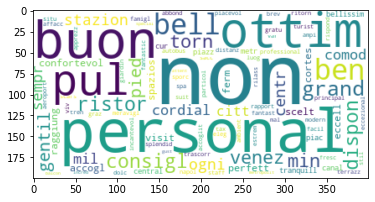

In [23]:
#faccio il wordcloud
lista_wordcloud2=[word for word in list_all_tokenized_lemmed_wordscloud if word in words]
stringa_wordcloud2=' '.join(lista_wordcloud2)
plt.imshow( WordCloud(collocations=False, stopwords=[], max_font_size=100, max_words=100, background_color="white", random_state=666).generate(stringa_wordcloud2), 
            interpolation='bilinear')

NGRAM SUI LEMMAS (uni e bi, con discorso sul 'non')

In [0]:
total_df['stringa_text_tokenized_lemmed']=total_df['text_tokenized_lemmed'].apply(lambda x: ' '.join(x))

In [0]:
def do_ngrams(stringa_review):
  # Break sentence in the token, remove empty tokens
  tokenss = [tokenn for tokenn in stringa_review.split(" ") if tokenn != ""]    
  # Use the zip function to help us generate n-grams
  # Concatentate the tokens into ngrams and return
  ngrams = zip(*[tokenss[i:] for i in range(2)])
  lista_di_tuple=list(ngrams)

  lista_ngrams=[]
  neg_found=False
  for i in range (len(lista_di_tuple)):
    if(lista_di_tuple[i][0]=='non'):
      lista_ngrams.append(lista_di_tuple[i][0]+lista_di_tuple[i][1])
      neg_found=True
    else:
      if neg_found==True:
        #lista_ngrams.append(lista_di_tuple[i][0]+lista_di_tuple[i][1]) #da provare con o senza
        neg_found=False
      else:
        lista_ngrams.append(lista_di_tuple[i][0])
        lista_ngrams.append(lista_di_tuple[i][0]+lista_di_tuple[i][1])
        neg_found=False

  if neg_found==False:
    lista_ngrams.append(lista_di_tuple[len(lista_di_tuple)-1][1])
  
  return ' '.join(lista_ngrams)

In [26]:
do_ngrams("ciao io non consiglio mai")

'ciao ciaoio io ionon nonconsiglio mai'

In [0]:
total_df['stringa_ngrams']=total_df['stringa_text_tokenized_lemmed'].apply(do_ngrams)

AGGIUNGO EMOTICONS E PUNTEGGIATURA IMPORTANTE AGLI NGRAMS

In [0]:
def add_punct_to_ngrams(row):
  stringa_ngrams=row['stringa_ngrams']
  regex_puntoesc=re.compile('\w![^!]') #perchè ho visto no correlaz tra aumentare i ! e aumentare positività 
  count_puntoesc=len(regex_puntoesc.findall(row['text']))
  for i in range(count_puntoesc):
    stringa_ngrams=stringa_ngrams+" !"

  regex_puntointerr=re.compile('\?') #perchè ho visto correlaz tra aumentare i ? e aumentare negatività
  count_puntointerr=len(regex_puntointerr.findall(row['text']))
  for i in range(count_puntointerr):
    stringa_ngrams=stringa_ngrams+" ?"

  return stringa_ngrams


def add_emoji_to_ngrams(row):
  stringa_ngrams=row['stringa_ngrams']
  regex_good=re.compile(pos_emoticons_regex+'|'+pos_emojis_regex)
  
  count_good=regex_good.findall(row['text'])
  for i in range(len(count_good)):
    stringa_ngrams=stringa_ngrams+" faccinafelice123"

  regex_bad=re.compile(neg_emoticons_regex+'|'+neg_emojis_regex)
  count_bad=regex_bad.findall(row['text'])
  for i in range(len(count_bad)):
    stringa_ngrams=stringa_ngrams+" faccinatriste123"

  return stringa_ngrams

In [0]:
#aggiungo qualche punteggiatura (scelta vedendo le statistiche)
#nella stringa_ngrams
total_df['stringa_ngrams']=total_df.apply(add_punct_to_ngrams, axis=1)

In [0]:
#tutte le emticons/emoji positive le codifico con faccinafelice123
#quelle negative con faccinatriste123
total_df['stringa_ngrams']=total_df.apply(add_emoji_to_ngrams, axis=1)

In [0]:
#total_df.iloc[27].loc['text']  snippet per accedere ad una cella specifica

In [32]:
total_df

,text,class,has_pos_emoj_emot,has_neg_emoj_emot,text_tokenized_lemmed,stringa_text_tokenized_lemmed,stringa_ngrams
0,Non è l'hotel più lussuoso in cui abbia mai so...,pos,False,False,"[non, hotel, lussuos, mai, soggiorn, esperit, ...",non hotel lussuos mai soggiorn esperit comples...,nonhotel lussuos lussuosmai mai maisoggiorn so...
1,Siamo stati qui per 1 notte prima della nostra...,pos,False,False,"[stat, nott, prim, sinistr, crocier, venez, pe...",stat nott prim sinistr crocier venez personal ...,stat statnott nott nottprim prim primsinistr s...
2,Hotel è ben posizionato per visitare Torino. A...,pos,False,False,"[hotel, ben, posizion, visit, torin, circ, m, ...",hotel ben posizion visit torin circ m ferm aut...,hotel hotelben ben benposizion posizion posizi...
3,All'arrivo la cordialità e disponibilità dello...,pos,False,False,"[arriv, cordial, disponibil, staff, qualit, ca...",arriv cordial disponibil staff qualit camer al...,arriv arrivcordial cordial cordialdisponibil d...
4,Abbiamo soggiornato per due notti alla fine de...,pos,False,False,"[soggiorn, due, nott, fin, crocier, personal, ...",soggiorn due nott fin crocier personal molt co...,soggiorn soggiorndue due duenott nott nottfin ...
...,...,...,...,...,...,...,...
41072,"A due passi dal bioparco zoom di Torino, abbia...",NaN,False,False,"[due, pass, bioparc, zoom, torin, dorm, nott, ...",due pass bioparc zoom torin dorm nott grazios ...,due duepass pass passbioparc bioparc bioparczo...
41073,Non esiste lobby ma si fa il check in in auto ...,NaN,False,False,"[non, esist, lobby, far, check, aut, rec, dire...",non esist lobby far check aut rec dirett camer...,nonesist lobby lobbyfar far farcheck check che...
41074,Quattro giorni paese e paesaggi stupendi. Rapp...,NaN,False,False,"[quattr, giorn, paes, paesagg, stup, rapport, ...",quattr giorn paes paesagg stup rapport qualit ...,quattr quattrgiorn giorn giornpaes paes paespa...
41075,A parte la posizione non riesco a trovare alcu...,NaN,False,False,"[part, posizion, non, riusc, trov, alcun, punt...",part posizion non riusc trov alcun punt posit ...,part partposizion posizion posizionnon nonrius...


VETTORIZZAZIONE DEL DATAFRAME (FIT SOLO SUI LABELLED)

In [0]:
vectorizer = TfidfVectorizer(input='content', encoding='utf-8', decode_error='strict', strip_accents=None, lowercase=True, preprocessor=None, tokenizer=None, 
                             analyzer='word',
                             stop_words=None,
                             ngram_range=(1,1),
                             max_df=0.9, min_df=5, max_features=None,
                             vocabulary=None, binary=False, 
                             norm='l2', 
                             use_idf=True, smooth_idf=True, 
                             sublinear_tf=False)
vectorizer = vectorizer.fit(total_df['stringa_ngrams'][:number_of_labelled]) #traino vocabolario solo sul training set
#perchè non mi interessa vedere anche l'evaluation set perchè non so le label, non ha senso ad es calcolare la min e max df anche su quel set

sparse_matrix=vectorizer.transform(total_df['stringa_ngrams'])
#sparse matrix con row documenti e colonne le features create (il cui indice lo ricavo nel vocabulary)

In [0]:
vectorizer.vocabulary_.get("hotelnon") #snippet per vedere se un ngrams è preso alla fine

23787

In [0]:
def dump_to_file(file, labels):
    with open(file, 'w', encoding='utf-8', newline='') as writeFile:
        writer = csv.writer(writeFile)
        writer.writerow(['Id', 'Predicted'])
        writer.writerows(enumerate(labels))


LinearSVC 

In [0]:
from sklearn.svm import LinearSVC
classifier=LinearSVC(class_weight='balanced')
classifier.fit(sparse_matrix[:number_of_labelled], total_df['class'][:number_of_labelled])
y_pred=classifier.predict(sparse_matrix)

dump_to_file('res.csv', y_pred[number_of_labelled:])

In [48]:
sparse_matrix.shape

(41077, 59319)

CROSS VALIDATION

In [53]:
from sklearn.model_selection import ParameterGrid, train_test_split
from sklearn.metrics import f1_score

y_true=total_df['class'][:number_of_labelled]

params = {
"tol":[1e-2, 1e-3, 1e-4,1e-6,1e-7],
"C":[0.5,1.0,2.0,3.0],
"fit_intercept": [True,False],
'max_iter':[1000,3000]
}

from sklearn.model_selection import StratifiedKFold
X_train_valid, X_test, y_train_valid, y_test=train_test_split(sparse_matrix[:number_of_labelled], np.array(y_true),
                                                              stratify=np.array(y_true))

# stratify fa in modo di ottenere la stessa distribuzione delle labels
kf = StratifiedKFold(5)
mean_accuracies = []
for config in ParameterGrid(params):
  clf_accuracies = []
  counts = []
  for train_indices, valid_indices in kf.split(X_train_valid, y_train_valid):
    X_train = X_train_valid[train_indices]
    y_train = y_train_valid[train_indices]
    X_valid = X_train_valid[valid_indices]
    y_valid = y_train_valid[valid_indices]

    counts.append(len(train_indices)) #fissati i parametri farò media della metrica pesata sulle size dei train set ottenuti nel kfold
  
    #QUI CI METTO I VECTORIZER, E ALTRE COSE DI PRIMA SE VOGLIO SU CUI FARE LA GRIDSEARCH
    classifier=LinearSVC(**config, random_state=1) #fisso il random state uguale per tutti cosi
    classifier.fit(X_train, y_train)
    y_pred=classifier.predict(X_valid)

    acc=f1_score(y_valid, y_pred, average='weighted') #weighted a seconda del supporto delle labels(sono 2 qui)
    clf_accuracies.append(acc)
  mean_acc = np.average(clf_accuracies, weights=counts) #media sui fold per quella config di parametri
  print(mean_acc, str(config))
  mean_accuracies.append(mean_acc)

0.9663642277031095 {'C': 0.5, 'fit_intercept': True, 'max_iter': 1000, 'tol': 0.01}
0.9662697389352553 {'C': 0.5, 'fit_intercept': True, 'max_iter': 1000, 'tol': 0.001}
0.9662697389352553 {'C': 0.5, 'fit_intercept': True, 'max_iter': 1000, 'tol': 0.0001}
0.9662697389352553 {'C': 0.5, 'fit_intercept': True, 'max_iter': 1000, 'tol': 1e-06}
0.9662697389352553 {'C': 0.5, 'fit_intercept': True, 'max_iter': 1000, 'tol': 1e-07}
0.9663642277031095 {'C': 0.5, 'fit_intercept': True, 'max_iter': 3000, 'tol': 0.01}
0.9662697389352553 {'C': 0.5, 'fit_intercept': True, 'max_iter': 3000, 'tol': 0.001}
0.9662697389352553 {'C': 0.5, 'fit_intercept': True, 'max_iter': 3000, 'tol': 0.0001}
0.9662697389352553 {'C': 0.5, 'fit_intercept': True, 'max_iter': 3000, 'tol': 1e-06}
0.9662697389352553 {'C': 0.5, 'fit_intercept': True, 'max_iter': 3000, 'tol': 1e-07}
0.9663629341033072 {'C': 0.5, 'fit_intercept': False, 'max_iter': 1000, 'tol': 0.01}
0.9663629341033072 {'C': 0.5, 'fit_intercept': False, 'max_iter':

In [54]:
#alla fine della cross validation ho scelto LA BEST CONFIGURATION
#quindi traino sull' X_train_valid e predico X_test (che è labellato ma era rimasto comunque fuori)
#se ottengo un risultato gradevole posso TRAINARE su tutto il labelled e lo userò per trovare le label unknown
best_config = list(ParameterGrid(params))[np.argmax(mean_accuracies)]
classifier=LinearSVC(**best_config)
classifier.fit(X_train_valid, y_train_valid)
print(f1_score(y_test, classifier.predict(X_test), average='weighted'))

0.9648351803739017


In [0]:
#traino su tutto il labelled e predico le unknown
classifier=LinearSVC(**best_config)
classifier.fit(sparse_matrix[:number_of_labelled], total_df['class'][:number_of_labelled])
all_prediction_linear = classifier.predict(sparse_matrix)
def dump_to_file(file, labels):
    with open(file, 'w', encoding='utf-8', newline='') as writeFile:
        writer = csv.writer(writeFile)
        writer.writerow(['Id', 'Predicted'])
        writer.writerows(enumerate(labels))

dump_to_file('res.csv', all_prediction_linear[number_of_labelled:])

ALTRI TENTATIVI EFFETTUATI MA NON SCELTI NELLA VERSIONE FINALE

SUPPORT VECTOR MACHINE

In [0]:
#features_df=pd.DataFrame.sparse.from_spmatrix(sparse_matrix)
#cosi applico la SVM sulle feature che ho ottenuto dal vectorizer

# Perform classification with SVM, kernel=linear 
#classifier_linear = svm.SVC(kernel='linear')

#classifier_linear.fit(sparse_matrix[:number_of_labelled], total_df['class'][:number_of_labelled])
#traino solo sulle label

#PREDIZIONE
#all_prediction_linear = classifier_linear.predict(sparse_matrix)
#dump_to_file('res.csv', all_prediction_linear[number_of_labelled:])

RULE BASED

In [0]:
#def polarity(word):
#      return (np.array(total_df['class'][:number_of_labelled]  == 'pos') & np.array(total_df['text_tokenized_lemmed'][:number_of_labelled].apply(lambda text: word in text))).sum() / np.array(total_df['text_tokenized_lemmed'][:number_of_labelled] .apply(lambda text: word in text)).sum() * 100 


#commonwords = [x[0] for x in Counter(words).most_common()[:5000] ]

#polarity_words = {x: polarity(x) for x in commonwords }

#def polarity_review(review):
#    return np.array(list(map(lambda x: polarity_words.get(x, 50), review))).mean()



NAIVE BAYESIAN

In [0]:
#apriori_pos = (total_df['class'] == 'pos').sum() / number_of_labelled
#apriori_neg = (total_df['class'] == 'neg').sum() / number_of_labelled

#def feature_prob_pos(review):
#    return np.array(list(map(lambda x: polarity_words.get(x, 50) / 100, review))).prod()* apriori_pos 

#def feature_prob_neg(review):
#    return np.array(list(map(lambda x: 1-polarity_words.get(x, 50) / 100, review))).prod()* apriori_neg 

RANDOM FOREST

In [0]:
#params = {
#"max_depth": [None, 30, 40, 50],
#"min_impurity_decrease": [0, 1e-1, 1e-2, 1e-4],
#"n_estimators": [50,200,500]
#}
#X_train_valid, X_test, y_train_valid, y_test=train_test_split(sparse_matrix[:number_of_labelled], np.array(y_true),                                                              stratify=np.array(y_true))
#kf = StratifiedKFold(5)
#accuracies = []
#for config in ParameterGrid(params):
#  clf_accuracies = []
#  counts = []
#  for train_indices, valid_indices in kf.split(X_train_valid, y_train_valid):
#    X_train = X_train_valid[train_indices]
#    y_train = y_train_valid[train_indices]
#    X_valid = X_train_valid[valid_indices]
#    y_valid = y_train_valid[valid_indices]
#    counts.append(len(train_indices))
#    clf = RandomForestClassifier(**config, random_state=1)
#    clf.fit(X_train, y_train)
#    y_pred=clf.predict(X_valid)
#    acc = f1_score(y_valid, y_pred, average='weighted')
#    clf_accuracies.append(acc)
#  mean_acc = np.average(clf_accuracies, weights=counts)
#  accuracies.append(mean_acc)
